# Tutorial 2 : Playing with MNIST dataset using LeNet-5 and MNISTNet

## A PyTorch implementation to: [Rotation equivariant vector field networks](https://github.com/COGMAR/RotEqNet), ICCV 2017

### Go to your IPython working directory in bash and copy this command:
### git clone https://github.com/COGMAR/RotEqNet.git

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import transforms,datasets
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import sys
sys.path.insert(0, '/home/sprakashdash/Documents/DLFA/RotEqNet/') # change path accordingly
from layers_2D import RotConv, VectorMaxPool, VectorBatchNorm, Vector2Magnitude, VectorUpsampling
import matplotlib.pyplot as plt
import time

## Load data:

In [2]:
apply_transform = transforms.Compose([transforms.Resize(32),transforms.ToTensor()])
apply_transform_rot = transforms.Compose([transforms.Resize(32),transforms.RandomRotation(90),transforms.ToTensor()])
BatchSize = 256 # change according to system specs

trainset = datasets.MNIST(root='./MNIST', train=True, download=True, transform=apply_transform)
trainsetRot = datasets.MNIST(root='./MNIST', train=True, download=True, transform=apply_transform_rot)
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=BatchSize,
                                          shuffle=True, num_workers=4) # Creating dataloader
trainLoaderRot = torch.utils.data.DataLoader(trainsetRot, batch_size=BatchSize,
                                          shuffle=True, num_workers=4) # Creating dataloader

# Validation set with random rotations in the range [-90,90]
testsetRot = datasets.MNIST(root='./MNIST', train=False, download=True, transform=apply_transform_rot)
testLoaderRot = torch.utils.data.DataLoader(testsetRot, batch_size=BatchSize,
                                         shuffle=False, num_workers=4) # Creating dataloader

In [3]:
# Size of train and test datasets
print('No. of samples in train set: '+str(len(trainLoader.dataset)))
print('No. of samples in test set: '+str(len(testLoaderRot.dataset)))

No. of samples in train set: 60000
No. of samples in test set: 10000


## Define network architecture

### LeNet-5

In [4]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)        
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 400)
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x,dim=1)


### MNISTNet

In [5]:
class MnistNet(nn.Module):
    def __init__(self):
        super(MnistNet, self).__init__()

        self.main = nn.Sequential(           
            RotConv(1, 6, [9, 9], 1, 9 // 2, n_angles=17, mode=1), #The first RotConv must have mode=1 
            VectorMaxPool(2),
            VectorBatchNorm(6),
            
            RotConv(6, 16, [9, 9], 1, 9 // 2, n_angles=17, mode=2), #The next RotConv has mode=2 (since the input is vector field)
            VectorMaxPool(2),
            VectorBatchNorm(16),
            
            RotConv(16, 32, [9, 9], 2, 1, n_angles=17, mode=2), # changed stride 1->2
            Vector2Magnitude(), #This call converts the vector field to a conventional multichannel image/feature image
            
        )
        self.linear = nn.Sequential(
            nn.Linear(32,128),
            nn.Dropout2d(0.7),
            nn.Linear(128,10)               
        )

    def forward(self,x):
        x = self.main(x)
        x = x.view(-1,32)
        x = self.linear(x)
        return  F.log_softmax(x,dim=1)

## Train the networks on vanilla MNIST and validate on MNIST with random rotations

### Initialize networks

In [6]:
net1 = LeNet() 
net2 = MnistNet()
print(net1)
print(net2)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
MnistNet(
  (main): Sequential(
    (0): RotConv()
    (1): VectorMaxPool()
    (2): VectorBatchNorm()
    (3): RotConv()
    (4): VectorMaxPool()
    (5): VectorBatchNorm()
    (6): RotConv()
    (7): Vector2Magnitude()
  )
  (linear): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): Dropout2d(p=0.7)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [7]:
# Check availability of GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')   
    net1 = net1.cuda()
    net2 = net2.cuda()

GPU is available!


### Define loss function and optimizer

In [8]:
criterion = nn.NLLLoss() # Negative Log-likelihood
optimizer1 = optim.SGD(net1.parameters(), lr=1e-2, momentum=0.9) # SGD
optimizer2 = optim.SGD(net2.parameters(), lr=1e-2, momentum=0.9) # SGD

### Training and validation routine

Iteration: 1 /10  ; LeNet:  Training Loss: 0.005049 ; Testing Acc: 46.760 ; Time consumed: 7m 51s 
Iteration: 1 /10  ; MNISTNet:  Training Loss: 0.002655 ; Testing Acc: 67.110 ; Time consumed: 7m 51s 
Iteration: 2 /10  ; LeNet:  Training Loss: 0.000775 ; Testing Acc: 51.650 ; Time consumed: 8m 12s 
Iteration: 2 /10  ; MNISTNet:  Training Loss: 0.000614 ; Testing Acc: 68.790 ; Time consumed: 8m 12s 
Iteration: 3 /10  ; LeNet:  Training Loss: 0.000437 ; Testing Acc: 53.070 ; Time consumed: 8m 8s 
Iteration: 3 /10  ; MNISTNet:  Training Loss: 0.000459 ; Testing Acc: 72.370 ; Time consumed: 8m 8s 
Iteration: 4 /10  ; LeNet:  Training Loss: 0.000334 ; Testing Acc: 53.080 ; Time consumed: 8m 7s 
Iteration: 4 /10  ; MNISTNet:  Training Loss: 0.000402 ; Testing Acc: 73.680 ; Time consumed: 8m 7s 
Iteration: 5 /10  ; LeNet:  Training Loss: 0.000278 ; Testing Acc: 53.210 ; Time consumed: 7m 38s 
Iteration: 5 /10  ; MNISTNet:  Training Loss: 0.000324 ; Testing Acc: 74.260 ; Time consumed: 7m 38s 

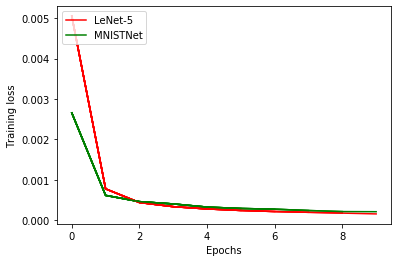

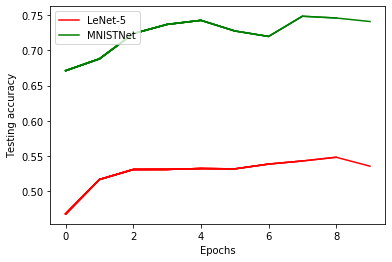

In [9]:
iterations = 10
trainLoss1 = [] # list for saving training loss of LeNet
testAcc1 = [] # list for saving test accuracy of LeNet
trainLoss2 = [] # list for saving training loss of MNISTNet
testAcc2 = [] # list for saving test accuracy of MNISTNet
for epoch in range(iterations):
    epochStart = time.time()
    runningLoss1 = 0 # accumulated loss for LeNet   
    runningLoss2 = 0 # accumulated loss for MNISTNet      
    net1.train(True) # For training
    net2.train(True) 
    for data in trainLoader:
        inputs,labels = data
        # Wrap them in Variable
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)  
       
        # Initialize gradients to zero
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        # Feed-forward input data through the network        
        outputs1 = net1(inputs)        
        outputs2 = net2(inputs)        
        # Compute loss/error
        loss1 = criterion(outputs1, labels)
        loss2 = criterion(outputs2, labels)
        # Backpropagate loss and compute gradients
        loss1.backward()
        loss2.backward()
        # Update the network parameters
        optimizer1.step()
        optimizer2.step()
        # Accumulate loss per batch
        runningLoss1 += loss1.data.item()
        runningLoss2 += loss2.data.item()
    avgTrainLoss1 = runningLoss1/60000.0
    avgTrainLoss2 = runningLoss2/60000.0
    trainLoss1.append(avgTrainLoss1)
    trainLoss2.append(avgTrainLoss2)
    
    # Evaluating performance on test set for each epoch
    with torch.no_grad(): # for evaluation
        running_correct1 = 0
        running_correct2 = 0
        for data in testLoaderRot:
            inputs,labels = data
            # Wrap them in Variable
            if use_gpu:
                inputs = Variable(inputs.cuda())                
                outputs1 = net1(inputs)
                outputs2 = net2(inputs)
                _, predicted1 = torch.max(outputs1.data, 1)
                _, predicted2 = torch.max(outputs2.data, 1)
                predicted1 = predicted1.cpu()
                predicted2 = predicted2.cpu()
            else:
                inputs = Variable(inputs)
                outputs1 = net1(inputs)
                outputs2 = net2(inputs)
                _, predicted1 = torch.max(outputs1.data, 1)
                _, predicted2 = torch.max(outputs1.data, 1)
            running_correct1 += (predicted1 == labels).sum()
            running_correct2 += (predicted2 == labels).sum()
        avgTestAcc1 = float(running_correct1)/10000.0
        avgTestAcc2 = float(running_correct2)/10000.0
        testAcc1.append(avgTestAcc1)
        testAcc2.append(avgTestAcc2)
        
    # Plotting training loss vs Epochs
    fig1 = plt.figure(1)        
    plt.plot(range(epoch+1),trainLoss1,'r-',label='LeNet-5')        
    plt.plot(range(epoch+1),trainLoss2,'g-',label='MNISTNet')        
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Training loss')   
    # Plotting testing accuracy vs Epochs
    fig2 = plt.figure(2)        
    plt.plot(range(epoch+1),testAcc1,'r-',label='LeNet-5')        
    plt.plot(range(epoch+1),testAcc2,'g-',label='MNISTNet')        
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Testing accuracy')    
    epochEnd = time.time()-epochStart
    print('Iteration: {:.0f} /{:.0f}  ; LeNet:  Training Loss: {:.6f} ; Testing Acc: {:.3f} ; Time consumed: {:.0f}m {:.0f}s '\
          .format(epoch + 1,iterations,avgTrainLoss1,avgTestAcc1*100,epochEnd//60,epochEnd%60))
    print('Iteration: {:.0f} /{:.0f}  ; MNISTNet:  Training Loss: {:.6f} ; Testing Acc: {:.3f} ; Time consumed: {:.0f}m {:.0f}s '\
          .format(epoch + 1,iterations,avgTrainLoss2,avgTestAcc2*100,epochEnd//60,epochEnd%60))



## Train and validate the networks on MNIST with random rotations

### Initialize networks

In [10]:
net1 = LeNet()
net2 = MnistNet()
# Check availability of GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')   
    net1 = net1.cuda()
    net2 = net2.cuda()
criterion = nn.NLLLoss() # Negative Log-likelihood
optimizer1 = optim.SGD(net1.parameters(), lr=1e-2, momentum=0.9) # SGD with momentum
optimizer2 = optim.SGD(net2.parameters(), lr=1e-2, momentum=0.9) # SGD with momentum

GPU is available!


### Training and validation routine

Iteration: 1 /10  ; LeNet:  Training Loss: 0.007286 ; Testing Acc: 68.880 ; Time consumed: 9m 34s 
Iteration: 1 /10  ; MNISTNet:  Training Loss: 0.005218 ; Testing Acc: 86.580 ; Time consumed: 9m 34s 
Iteration: 2 /10  ; LeNet:  Training Loss: 0.002363 ; Testing Acc: 89.010 ; Time consumed: 9m 36s 
Iteration: 2 /10  ; MNISTNet:  Training Loss: 0.001340 ; Testing Acc: 91.720 ; Time consumed: 9m 36s 
Iteration: 3 /10  ; LeNet:  Training Loss: 0.001216 ; Testing Acc: 92.450 ; Time consumed: 9m 33s 
Iteration: 3 /10  ; MNISTNet:  Training Loss: 0.000943 ; Testing Acc: 94.210 ; Time consumed: 9m 33s 
Iteration: 4 /10  ; LeNet:  Training Loss: 0.000892 ; Testing Acc: 93.470 ; Time consumed: 9m 33s 
Iteration: 4 /10  ; MNISTNet:  Training Loss: 0.000808 ; Testing Acc: 94.480 ; Time consumed: 9m 33s 
Iteration: 5 /10  ; LeNet:  Training Loss: 0.000758 ; Testing Acc: 94.660 ; Time consumed: 8m 14s 
Iteration: 5 /10  ; MNISTNet:  Training Loss: 0.000710 ; Testing Acc: 95.270 ; Time consumed: 8m 

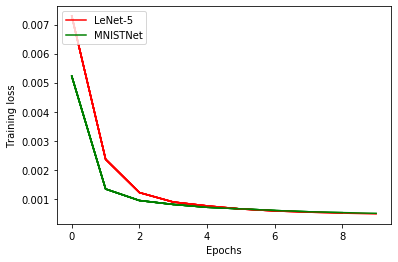

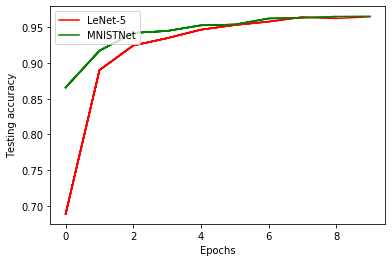

In [11]:
iterations = 10
trainLoss1 = []
testAcc1 = []
trainLoss2 = []
testAcc2 = []
for epoch in range(iterations):
    epochStart = time.time()
    runningLoss1 = 0    
    runningLoss2 = 0    
    net1.train(True) # For training
    net2.train(True) 
    for data in trainLoaderRot:
        inputs,labels = data
        # Wrap them in Variable
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), \
                Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)  
       
        # Initialize gradients to zero
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        # Feed-forward input data through the network        
        outputs1 = net1(inputs)        
        outputs2 = net2(inputs)        
        # Compute loss/error
        loss1 = criterion(outputs1, labels)
        loss2 = criterion(outputs2, labels)
        # Backpropagate loss and compute gradients
        loss1.backward()
        loss2.backward()
        # Update the network parameters
        optimizer1.step()
        optimizer2.step()
        # Accumulate loss per batch
        runningLoss1 += loss1.data.item()
        runningLoss2 += loss2.data.item()
    avgTrainLoss1 = runningLoss1/60000.0
    avgTrainLoss2 = runningLoss2/60000.0
    trainLoss1.append(avgTrainLoss1)
    trainLoss2.append(avgTrainLoss2)
    
    # Evaluating performance on test set for each epoch
    with torch.no_grad():
        running_correct1 = 0
        running_correct2 = 0
        for data in testLoaderRot:
            inputs,labels = data
            # Wrap them in Variable
            if use_gpu:
                inputs = Variable(inputs.cuda())                
                outputs1 = net1(inputs)
                outputs2 = net2(inputs)
                _, predicted1 = torch.max(outputs1.data, 1)
                _, predicted2 = torch.max(outputs2.data, 1)
                predicted1 = predicted1.cpu()
                predicted2 = predicted2.cpu()
            else:
                inputs = Variable(inputs)
                outputs1 = net1(inputs)
                outputs2 = net2(inputs)
                _, predicted1 = torch.max(outputs1.data, 1)
                _, predicted2 = torch.max(outputs1.data, 1)
            running_correct1 += (predicted1 == labels).sum()
            running_correct2 += (predicted2 == labels).sum()
        avgTestAcc1 = float(running_correct1)/10000.0
        avgTestAcc2 = float(running_correct2)/10000.0
        testAcc1.append(avgTestAcc1)
        testAcc2.append(avgTestAcc2)
        
    # Plotting training loss vs Epochs
    fig1 = plt.figure(1)        
    plt.plot(range(epoch+1),trainLoss1,'r-',label='LeNet-5')        
    plt.plot(range(epoch+1),trainLoss2,'g-',label='MNISTNet')        
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Training loss')   
    # Plotting testing accuracy vs Epochs
    fig2 = plt.figure(2)        
    plt.plot(range(epoch+1),testAcc1,'r-',label='LeNet-5')        
    plt.plot(range(epoch+1),testAcc2,'g-',label='MNISTNet')        
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Testing accuracy')    
    epochEnd = time.time()-epochStart
    print('Iteration: {:.0f} /{:.0f}  ; LeNet:  Training Loss: {:.6f} ; Testing Acc: {:.3f} ; Time consumed: {:.0f}m {:.0f}s '\
          .format(epoch + 1,iterations,avgTrainLoss1,avgTestAcc1*100,epochEnd//60,epochEnd%60))
    print('Iteration: {:.0f} /{:.0f}  ; MNISTNet:  Training Loss: {:.6f} ; Testing Acc: {:.3f} ; Time consumed: {:.0f}m {:.0f}s '\
          .format(epoch + 1,iterations,avgTrainLoss2,avgTestAcc2*100,epochEnd//60,epochEnd%60))

